# Word Embedding

In [37]:
# load the packages
import json  
import re
from collections import Counter
import copy
import string
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize  
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, GlobalMaxPool1D, Dropout, Activation
from keras.layers.embeddings import Embedding
import keras.backend as K

import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

SEED = 42

In [38]:
# load the data
df = pd.read_csv('df_clean.csv')
desc = pd.read_csv('desc_clean.csv', lineterminator='\n')

In [39]:
# remove rows with no description
df = pd.concat([df.views_cat, desc], axis = 1)
df_nona = df.dropna(how = 'any')

In [40]:
# define docs and labels
docs = df_nona.description.tolist()
labels = df_nona.views_cat.tolist()

In [6]:
# tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(docs)

In [7]:
# define the vocab size
vocab_size = len(tokenizer.word_index) + 1

In [8]:
# find the max length of the description
max_length = df_nona.description.apply(lambda x: len(x)).max()

In [9]:
# integer encode the documents
encoded_docs = [one_hot(d, vocab_size) for d in docs]

# pad documents to a max length
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

# train test split
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels, test_size = 0.2, stratify = labels, random_state = SEED)

In [13]:
# define the model
def get_precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[get_precision])

# summarize the model
print(model.summary())

# fit the model
history = model.fit(X_train, y_train, epochs=10, validation_split = 0.1)

# evaluate the model
loss, precision = model.evaluate(X_test, y_test)
print('Precision: %f' % (precision*100))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 4880, 8)           1344576   
_________________________________________________________________
flatten_3 (Flatten)          (None, 39040)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 39041     
Total params: 1,383,617
Trainable params: 1,383,617
Non-trainable params: 0
_________________________________________________________________
None
Train on 85019 samples, validate on 9447 samples
Epoch 1/10
85019/85019 [==============================] - 56s 656us/step - loss: 0.2870 - get_precision: 0.7784 - val_loss: 0.1809 - val_get_precision: 0.8695
Epoch 2/10
85019/85019 [==============================] - 40s 471us/step - loss: 0.1536 - get_precision: 0.8824 - val_loss: 0.1610 - val_get_precision: 0.8773
Ep

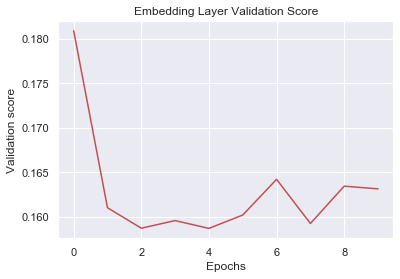

In [15]:
# Create the plot of the validation loss to compare different models
fit = plt.figure()

plt.plot(history.history['val_loss'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.title('Embedding Layer Validation Score')

plt.show()

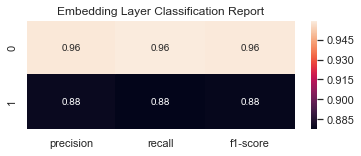

In [16]:
# visualize the classification report
yhat_classes = model.predict_classes(X_test)
yhat_classes = yhat_classes[:, 0]
clf_report = classification_report(y_test, yhat_classes, output_dict=True)
clf_report_df = pd.DataFrame(clf_report).iloc[:-1, :2].T
    
fig, ax = plt.subplots(figsize = (6, 2))
sns.heatmap(clf_report_df, annot=True)
plt.title('Embedding Layer Classification Report')
ax.set_ylim(len(clf_report_df)+0, -0)

fig.savefig('embedding.png', bbox_inches = 'tight')

plt.show()

<b> Transfer Learning

In [46]:
# create sequence
max_length = 300
vocab_size = 10000
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(docs)
sequences = tokenizer.texts_to_sequences(docs)
# max_length = df_nona.description.apply(lambda x: len(x)).max()
data = pad_sequences(sequences, maxlen=max_length)

In [42]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, stratify = labels, random_state = 42)

In [49]:
# extract word embeddings from the Glove
embeddings_index = dict()
f = open('glove.840B.300d.txt', 'r', errors = 'ignore', encoding='utf8')
for line in tqdm(f):
    values = line.split()
    word = ''.join(values[:-300])
    coefs = np.asarray(values[-300:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

2196017it [06:42, 5451.00it/s] 


In [50]:
# Create a weight matrix
embedding_matrix = np.zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [65]:
# define the model
model_glove = Sequential()
model_glove.add(Embedding(vocab_size, 300, input_length=max_length, weights=[embedding_matrix], trainable=True))
# model_glove.add(Dropout(0.2))
# model_glove.add(Conv1D(64, 5, activation='relu'))
# model_glove.add(MaxPooling1D(pool_size=4))
# model_glove.add(LSTM(100))
# model_glove.add(Dense(256, activation = 'relu'))
# model_glove.add(Dropout(0.5))
model_glove.add(Flatten())
model_glove.add(Dense(1, activation='sigmoid'))

# compile the model
model_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=[get_precision])

# summarize the model
print(model_glove.summary())

# fit the model
history_glove = model_glove.fit(X_train, y_train, epochs=5, validation_split = 0.1)

# evaluate the model
loss, precision = model_glove.evaluate(X_test, y_test)
print('Precision: %f' % (precision*100))

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 300, 300)          3000000   
_________________________________________________________________
flatten_9 (Flatten)          (None, 90000)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 90001     
Total params: 3,090,001
Trainable params: 3,090,001
Non-trainable params: 0
_________________________________________________________________
None
Train on 85019 samples, validate on 9447 samples
Epoch 1/5
85019/85019 [==============================] - 124s 1ms/step - loss: 0.4234 - get_precision: 0.8101 - val_loss: 0.4096 - val_get_precision: 0.8510
Epoch 2/5
85019/85019 [==============================] - 97s 1ms/step - loss: 0.3728 - get_precision: 0.8613 - val_loss: 0.3644 - val_get_precision: 0.8470
Epoch 

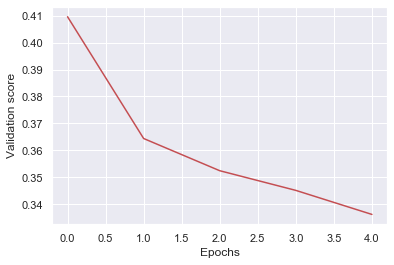

In [66]:
# create the plot of the validation loss
plt.plot(history_glove.history['val_loss'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

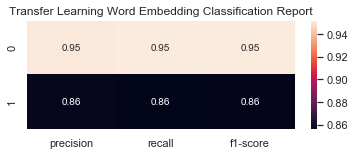

In [67]:
# visualize the classification report
yhat_classes = model_glove.predict_classes(X_test)
yhat_classes = yhat_classes[:, 0]
clf_report = classification_report(y_test, yhat_classes, output_dict=True)
clf_report_df = pd.DataFrame(clf_report).iloc[:-1, :2].T
    
fig, ax = plt.subplots(figsize = (6, 2))
sns.heatmap(clf_report_df, annot=True)
plt.title('Transfer Learning Word Embedding Classification Report')
ax.set_ylim(len(clf_report_df)+0, -0)

fig.savefig('tl_embedding.png', bbox_inches = 'tight')

plt.show()

In [69]:
# get weights
glove_embds = model_glove.layers[0].get_weights()[0]

# get word list
word_list = []
for word, i in tokenizer.word_index.items():
    word_list.append(word)

# plotting function
def plot_words(data, start, stop, step):
    trace = go.Scatter(
        x = data[start:stop:step,0], 
        y = data[start:stop:step, 1],
        mode = 'markers',
        text= word_list[start:stop:step]
    )
    layout = dict(title= 't-SNE 1 vs t-SNE 2',
                  yaxis = dict(title='t-SNE 2'),
                  xaxis = dict(title='t-SNE 1'),
                  hovermode= 'closest')
    fig = dict(data = [trace], layout= layout)
    py.offline.plot(fig, filename='tsne.html') 
    py.iplot(fig)

# visualize words in two dimensions 
glove_tsne_embds = TSNE(n_components=2).fit_transform(glove_embds)
fig = plot_words(glove_tsne_embds, 0, 2000, 1)